# Определение тональности комментариев

# 1. Загрузка бибилиотек и данных

## 1.1 Починка tensorflow

In [1]:
#pip install pymorphy2
# pip install pymorphy3
#pip install nltk
#pip install re
#pip install scikeras
# pip uninstall keras -y

In [2]:
# import sys
# print(sys.executable)

# import tensorflow as tf
# print(tf.__version__)

In [3]:
# pip uninstall tensorflow keras -y

In [4]:
# pip list | findstr tensor

In [5]:
# pip uninstall tensorboard tensorboard-data-server -y


In [6]:
# pip install tensorflow==2.20.0

In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential
print("tf.keras работает")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

KeyboardInterrupt: 

## 1.2 Реальная загрузка библиотек

In [8]:
import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('wordnet')
nltk.download('stopwords')

from string import punctuation

import pymorphy3

import re

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping


from scikeras.wrappers import KerasClassifier
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erikf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def creat_df():
    data_list = []
    with open("dataset.txt", encoding = 'utf-8') as file:
        for line in file:
            labels = line.split()[0]
            text = line[len(labels)+1:].strip()
            labels = labels.split(",")
            mask = [1 if "__label__NORMAL" in labels else 0,
                    1 if "__label__INSULT" in labels else 0,
                    1 if "__label__THREAT" in labels else 0,
                    1 if "__label__OBSCENITY" in labels else 0]
            data_list.append((text, *mask))
    return pd.DataFrame(data_list, columns=["comment", "normal", "insult", "threat", "obscenity"])

In [10]:
df = creat_df()
df

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0
...,...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,1,0,0
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0,0
248288,спасибо всем большое),1,0,0,0


In [11]:
df2 = pd.read_csv('labeled.csv')
df2

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


Датасеты созданы под разные семантические задачи, так что будем обучать две модели, одну для тональности, другу просто для классификации токсичности

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248290 entries, 0 to 248289
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    248290 non-null  object
 1   normal     248290 non-null  int64 
 2   insult     248290 non-null  int64 
 3   threat     248290 non-null  int64 
 4   obscenity  248290 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [13]:
df[['normal','insult','threat','obscenity']].sum()

normal       203685
insult        36826
threat        12027
obscenity      4261
dtype: int64

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


In [15]:
df.duplicated().sum()

np.int64(6)

In [16]:
df2.duplicated().sum()

np.int64(0)

In [17]:
df = df.drop_duplicates()

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
normal,248284.0,0.820355,0.383892,0.0,1.0,1.0,1.0,1.0
insult,248284.0,0.148322,0.355420,0.0,0.0,0.0,0.0,1.0
threat,248284.0,0.048432,0.214679,0.0,0.0,0.0,0.0,1.0
obscenity,248284.0,0.017162,0.129874,0.0,0.0,0.0,0.0,1.0


In [19]:
df.head(5)

,comment,normal,insult,threat,obscenity
0,скотина! что сказать,0,1,0,0
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0
4,а когда мы статус агрогородка получили?,1,0,0,0


In [20]:
df2.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


# Лемматизация + предобработка

## Очистка комментария

In [21]:
def clean_comment(comment):
    if not isinstance(comment, str):
        return ''
    
    urls = re.findall(r'https?://\S+|www\.\S+', comment)
    
    cleaned = re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', ' ', comment)
    
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    cleaned = re.sub("ё", "е", cleaned)

    
    if urls:
        cleaned += ' ' + ' '.join(urls)

    cleaned = cleaned.lower()
    
    return cleaned.strip()

In [22]:
df['comment_clean'] = df['comment'].apply(clean_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\2762205320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_clean'] = df['comment'].apply(clean_comment)


In [23]:
df2['comment_clean'] = df2['comment'].apply(clean_comment)

## Удаление стоп слов

In [24]:
stop_words = set(stopwords.words('russian'))

In [25]:
def remove_stopwords(comment):
    tokens = comment.split(' ')
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

In [26]:
df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\2137007685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_without_stop_words'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))


In [27]:
df2['comment_without_stop_words'] = df2['comment_clean'].apply(lambda x: remove_stopwords(x))


## Токенизация

In [28]:
def tokenize_comment(comment):
    return word_tokenize(comment, language='russian')

In [29]:
df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\495641482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_tokenize'] = df['comment_without_stop_words'].apply(tokenize_comment)


In [30]:
df2['comment_tokenize'] = df2['comment_without_stop_words'].apply(tokenize_comment)

In [31]:
df.head()

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize
0,скотина! что сказать,0,1,0,0,скотина что сказать,скотина сказать,"[скотина, сказать]"
1,я сегодня проезжала по рабочей и между домами ...,1,0,0,0,я сегодня проезжала по рабочей и между домами ...,сегодня проезжала рабочей домами снитенко гомо...,"[сегодня, проезжала, рабочей, домами, снитенко..."
2,очередной лохотрон. зачем придумывать очередно...,1,0,0,0,очередной лохотрон зачем придумывать очередной...,очередной лохотрон придумывать очередной налог...,"[очередной, лохотрон, придумывать, очередной, ..."
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0,0,ретро дежавю сложно понять чужое сердце лиш ощ...,ретро дежавю сложно понять чужое сердце лиш ощ...,"[ретро, дежавю, сложно, понять, чужое, сердце,..."
4,а когда мы статус агрогородка получили?,1,0,0,0,а когда мы статус агрогородка получили,статус агрогородка получили,"[статус, агрогородка, получили]"


In [32]:
df2.head(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,верблюдов то за что дебилы бл,верблюдов дебилы бл,"[верблюдов, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,хохлы это отдушина затюканого россиянина мол в...,хохлы это отдушина затюканого россиянина мол в...,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,собаке собачья смерть,собаке собачья смерть,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,страницу обнови дебил это тоже не оскорбление ...,страницу обнови дебил это оскорбление доказанн...,"[страницу, обнови, дебил, это, оскорбление, до..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,тебя не убедил страничный пдф в том что скрипа...,убедил страничный пдф скрипалей отравила росси...,"[убедил, страничный, пдф, скрипалей, отравила,..."


## Лемматизация

In [33]:
from pymorphy3 import MorphAnalyzer

In [34]:
morph = MorphAnalyzer()

In [35]:
def lemmatize(text: list) -> list:
    lemmas = [morph.parse(token)[0].normal_form for token in text]

    return lemmas

In [36]:
df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\117964416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_lemmatize'] = df['comment_tokenize'].apply(lemmatize)


In [37]:
df2['comment_lemmatize'] = df2['comment_tokenize'].apply(lemmatize)

In [38]:
df.sample(5)

,comment,normal,insult,threat,obscenity,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
245101,"обидно. они считают, что им всё дозволено. сты...",1,0,0,0,обидно они считают что им все дозволено стыд и...,обидно считают дозволено стыд позор,"[обидно, считают, дозволено, стыд, позор]","[обидно, считать, дозволить, стыд, позор]"
176337,у вас дом какого года?,1,0,0,0,у вас дом какого года,дом какого года,"[дом, какого, года]","[дом, какой, год]"
203013,калачики вкус,1,0,0,0,калачики вкус,калачики вкус,"[калачики, вкус]","[калачик, вкус]"
102899,вот вот ана будет саленая а хотите сладкую на ...,1,0,0,0,вот вот ана будет саленая а хотите сладкую на ...,ана саленая хотите сладкую это сахар,"[ана, саленая, хотите, сладкую, это, сахар]","[ана, салёный, хотеть, сладкий, это, сахар]"
168934,привет я тоже хачу транс секс куто хочит пишите,0,0,0,1,привет я тоже хачу транс секс куто хочит пишите,привет хачу транс секс куто хочит пишите,"[привет, хачу, транс, секс, куто, хочит, пишите]","[привет, хач, транс, секс, куть, хочить, писать]"


In [39]:
df2.sample(5)

,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize
7067,Можно про обсуждаемые батареи в цифрах? Ресурс...,0.0,можно про обсуждаемые батареи в цифрах ресурс ...,обсуждаемые батареи цифрах ресурс циклов заряд...,"[обсуждаемые, батареи, цифрах, ресурс, циклов,...","[обсуждать, батарея, цифра, ресурс, цикл, заря..."
2668,Сратый петух с вырвиглазными превьюхами и 256 ...,1.0,сратый петух с вырвиглазными превьюхами и подп...,сратый петух вырвиглазными превьюхами подписон...,"[сратый, петух, вырвиглазными, превьюхами, под...","[сратый, петух, вырвиглазной, превьюха, подпис..."
9315,Воскрешать надо неординарные решения в стиле и...,0.0,воскрешать надо неординарные решения в стиле и...,воскрешать неординарные решения стиле конфигур...,"[воскрешать, неординарные, решения, стиле, кон...","[воскрешать, неординарный, решение, стиль, кон..."
1422,Вы крутил бы ему все ниппеля и всё.,0.0,вы крутил бы ему все ниппеля и все,крутил ниппеля,"[крутил, ниппеля]","[крутило, ниппель]"
8256,Спорный вопрос.Я потенциальний покупатель.Дума...,0.0,спорный вопрос я потенциальний покупатель дума...,спорный вопрос потенциальний покупатель думаю ...,"[спорный, вопрос, потенциальний, покупатель, д...","[спорный, вопрос, потенциальний, покупатель, д..."


In [40]:
df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))
df2['comment_res'] =df2["comment_lemmatize"].apply(lambda x: ' '.join(x))
df.sample(5)
df2.sample(5)

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\618061841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comment_res'] =df["comment_lemmatize"].apply(lambda x: ' '.join(x))


,comment,toxic,comment_clean,comment_without_stop_words,comment_tokenize,comment_lemmatize,comment_res
9249,Вы определитесь: нужно производство-нужны день...,0.0,вы определитесь нужно производство нужны деньг...,определитесь нужно производство нужны деньги н...,"[определитесь, нужно, производство, нужны, ден...","[определиться, нужно, производство, нужный, де...",определиться нужно производство нужный деньга ...
8385,Смотри что бы из рука лицо не превратилась в л...,1.0,смотри что бы из рука лицо не превратилась в л...,смотри рука лицо превратилась левая рука пойду...,"[смотри, рука, лицо, превратилась, левая, рука...","[смотреть, рука, лицо, превратиться, левый, ру...",смотреть рука лицо превратиться левый рука пой...
3899,Все фильмы как на подбор. Особенно Железная хв...,0.0,все фильмы как на подбор особенно железная хватка,фильмы подбор особенно железная хватка,"[фильмы, подбор, особенно, железная, хватка]","[фильм, подбор, особенно, железный, хватка]",фильм подбор особенно железный хватка
6022,"два Какой наивный бридаун. Алсо, у тебя пробле...",1.0,два какой наивный бридаун алсо у тебя проблема...,наивный бридаун алсо проблема склонением загол...,"[наивный, бридаун, алсо, проблема, склонением,...","[наивный, бридаун, алсый, проблема, склонение,...",наивный бридаун алсый проблема склонение загол...
11951,Практика подобная была? Есть ли какой то спосо...,0.0,практика подобная была есть ли какой то способ...,практика подобная способ защититься суде страх...,"[практика, подобная, способ, защититься, суде,...","[практика, подобный, способ, защититься, суд, ...",практика подобный способ защититься суд страхо...


## Разделение на тестовую и тренировочную выборку

In [41]:
df = df[["comment_res", "normal", "insult", "threat", "obscenity"]]
df2 = df2[["comment_res", "toxic"]]

In [ ]:
df.to_csv('df1.csv')
df2.to_csv('df2.csv')

In [42]:
X = df["comment_res"].values
y = df[["normal", "insult", "threat", "obscenity"]].values

In [43]:
X2 = df2["comment_res"].values
y2 = df2["toxic"].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [45]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.8, random_state=42, stratify=y2)


## Обучение

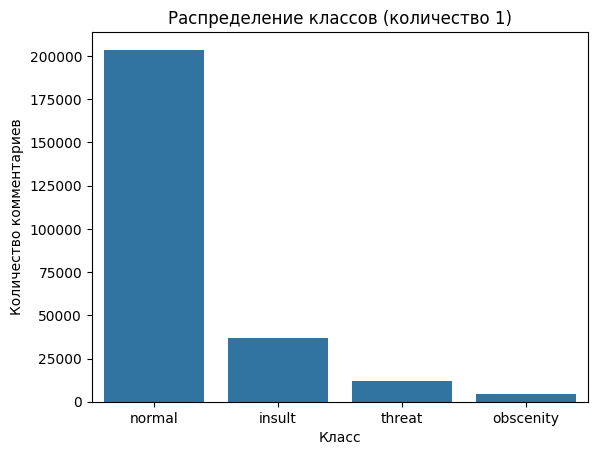

In [46]:
class_counts = df[['normal','insult','threat','obscenity']].sum()

sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)

plt.title('Распределение классов (количество 1)')
plt.ylabel('Количество комментариев')
plt.xlabel('Класс')
plt.show()

Heatmap решил не выводить, тк не понял его смысла

C:\Users\erikf\AppData\Local\Temp\ipykernel_9316\3912851465.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)


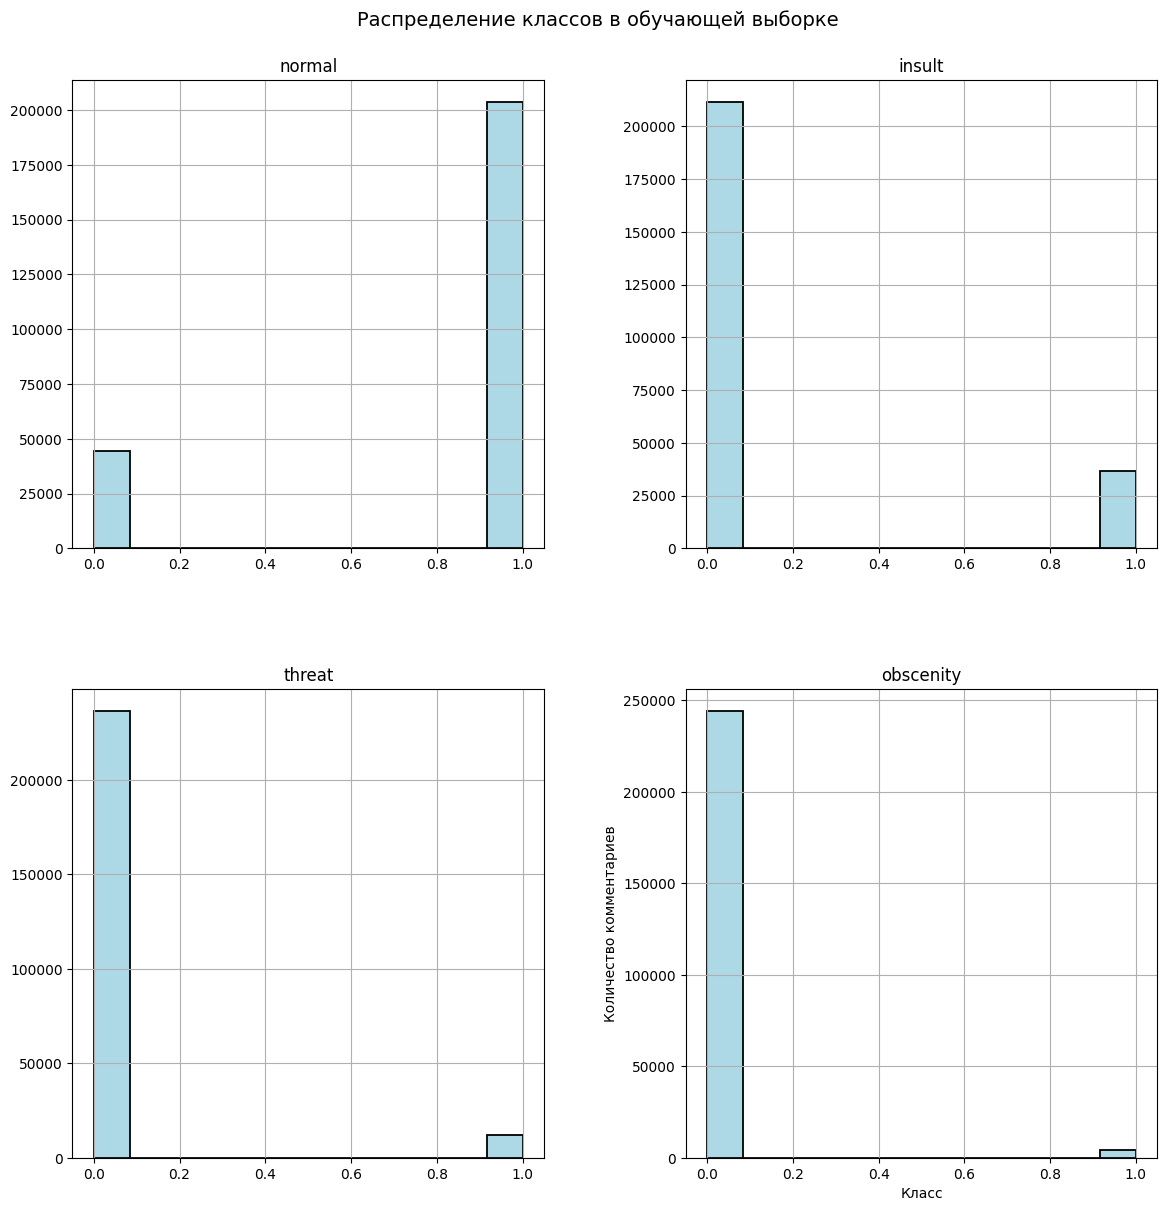

In [47]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Распределение классов в обучающей выборке',y = 0.93,size = 14)
plt.xlabel("Класс")
plt.ylabel("Количество комментариев")
plt.show()

## Padding

In [48]:
MAX_WORDS = 50000
MAX_LEN = 80

tokenizer = text.Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['comment_res'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=MAX_LEN)


In [49]:
import pickle

with open("tokenizer_mult.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


# Задача 1

In [50]:
def build_lstm():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [51]:
def build_cnn():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [52]:
def build_cnn_lstm():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Bidirectional(GRU(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [53]:

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True,  
    verbose=1
)

In [54]:
y_labels = np.argmax(y_train, axis=1)  
classes = np.unique(y_labels)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_labels)
class_weight_dict = dict(zip(classes, weights))

print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.3048595933302227), np.int64(1): np.float64(1.684993213437394), np.int64(2): np.float64(11.091523341523342), np.int64(3): np.float64(27.648524498886413)}


In [55]:
model = build_cnn_lstm()

history = model.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1242/1242 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - AUC: 0.8918 - loss: 0.3704 - val_AUC: 0.9646 - val_loss: 0.2029
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - AUC: 0.9586 - loss: 0.2290 - val_AUC: 0.9381 - val_loss: 0.2608
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - AUC: 0.9718 - loss: 0.1769 - val_AUC: 0.9461 - val_loss: 0.2472
Epoch 4/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 86s 70ms/step - AUC: 0.9793 - loss: 0.1450 - val_AUC: 0.9565 - val_loss: 0.2247
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [56]:
model2 = build_lstm()

history2 = model2.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 128s 100ms/step - AUC: 0.9542 - loss: 0.2429 - val_AUC: 0.9842 - val_loss: 0.1274
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - AUC: 0.9906 - loss: 0.1041 - val_AUC: 0.9861 - val_loss: 0.1180
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 121s 98ms/step - AUC: 0.9944 - loss: 0.0710 - val_AUC: 0.9888 - val_loss: 0.1069
Epoch 4/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - AUC: 0.9957 - loss: 0.0546 - val_AUC: 0.9866 - val_loss: 0.1182
Epoch 5/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 121s 98ms/step - AUC: 0.9968 - loss: 0.0459 - val_AUC: 0.9854 - val_loss: 0.1240
Epoch 6/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 119s 96ms/step - AUC: 0.9974 - loss: 0.0390 - val_AUC: 0.9860 - val_loss: 0.1193
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [57]:
model3 = build_cnn()

history3 = model3.fit(X_train_pad, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping],class_weight=class_weight_dict)

Epoch 1/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 70s 55ms/step - AUC: 0.8977 - loss: 0.3477 - val_AUC: 0.9242 - val_loss: 0.2976
Epoch 2/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - AUC: 0.9592 - loss: 0.2208 - val_AUC: 0.9446 - val_loss: 0.2512
Epoch 3/20
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 69s 56ms/step - AUC: 0.9728 - loss: 0.1725 - val_AUC: 0.9546 - val_loss: 0.2269
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


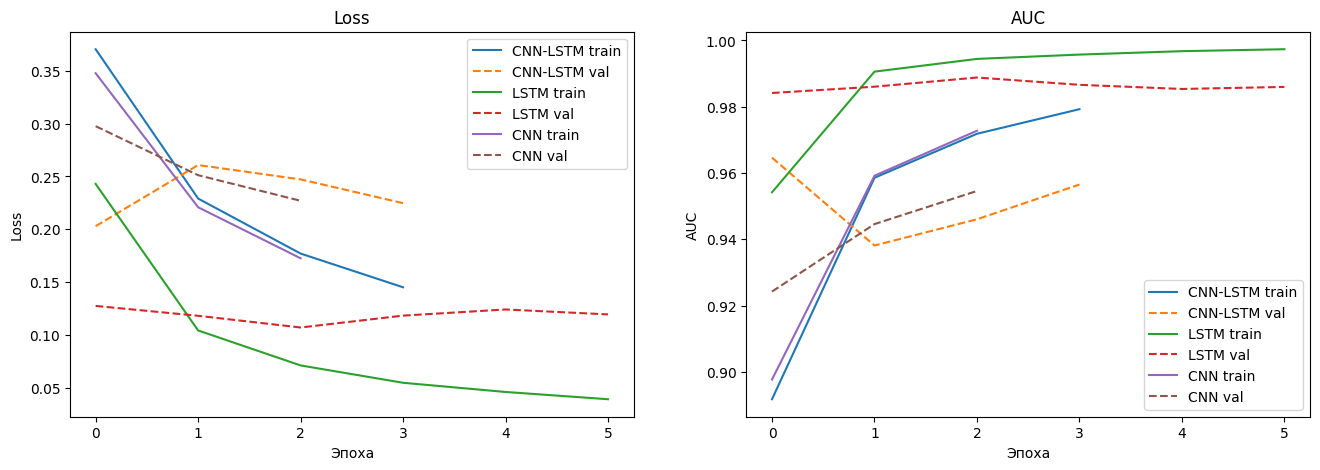

In [58]:
def plot_history_multiclass(histories, model_names):
    plt.figure(figsize=(16,5))
    
    # Losss
    plt.subplot(1,2,1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} train')
        plt.plot(history.history['val_loss'], '--', label=f'{name} val')
    plt.title('Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    
    # AUC
    plt.subplot(1,2,2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['AUC'], label=f'{name} train')
        plt.plot(history.history['val_AUC'], '--', label=f'{name} val')
    plt.title('AUC')
    plt.xlabel('Эпоха')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.show()

plot_history_multiclass(
    [history, history2, history3], 
    ['CNN-LSTM', 'LSTM', 'CNN']
)


В этой задаче лучше всего себя показала модель LSTM, в приложении streamlit будем использовать ее

# Задача 2

In [59]:
tokenizer2 = text.Tokenizer(num_words=MAX_WORDS)
tokenizer2.fit_on_texts(X2_train)

X2_train_seq = tokenizer2.texts_to_sequences(X2_train)
X2_test_seq = tokenizer2.texts_to_sequences(X2_test)

X2_train_pad = sequence.pad_sequences(X2_train_seq, maxlen=MAX_LEN)
X2_test_pad = sequence.pad_sequences(X2_test_seq, maxlen=MAX_LEN)


In [60]:
with open("tokenizer_bin.pkl", "wb") as f:
    pickle.dump(tokenizer2, f)


In [61]:
def build_cnn_lstm_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    
    model.add(Bidirectional(GRU(64)))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    
    return model


In [62]:
def build_lstm_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(GRU(64)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


In [63]:
def build_cnn_binary():
    model = Sequential()
    model.add(Embedding(MAX_WORDS, 128, input_length=MAX_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['AUC']
    )
    return model


## EarlyStopping

In [64]:
early_stopping_bin = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

## LSTM

In [65]:
model_lstm = build_lstm_binary()


In [66]:
history_bin = model_lstm.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - AUC: 0.7374 - loss: 0.5468 - val_AUC: 0.8757 - val_loss: 0.4194
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - AUC: 0.9630 - loss: 0.2285 - val_AUC: 0.9110 - val_loss: 0.3972
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - AUC: 0.9932 - loss: 0.0901 - val_AUC: 0.9083 - val_loss: 0.4480
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - AUC: 0.9988 - loss: 0.0343 - val_AUC: 0.8989 - val_loss: 0.6085
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - AUC: 0.9995 - loss: 0.0183 - val_AUC: 0.8933 - val_loss: 0.6239
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [67]:
y2_pred_prob = model_lstm.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
ROC-AUC: 0.9134269289577334
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88      1918
         1.0       0.74      0.82      0.78       965

    accuracy                           0.84      2883
   macro avg       0.82      0.84      0.83      2883
weighted avg       0.85      0.84      0.84      2883



## CNN

In [68]:
model_cnn = build_cnn_binary()


c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [69]:
history_bin2 = model_cnn.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - AUC: 0.6834 - loss: 0.5920 - val_AUC: 0.8489 - val_loss: 0.4753
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - AUC: 0.9464 - loss: 0.2850 - val_AUC: 0.9239 - val_loss: 0.3322
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - AUC: 0.9917 - loss: 0.1097 - val_AUC: 0.9205 - val_loss: 0.3807
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - AUC: 0.9977 - loss: 0.0513 - val_AUC: 0.9176 - val_loss: 0.4390
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - AUC: 0.9990 - loss: 0.0326 - val_AUC: 0.9082 - val_loss: 0.5143
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [70]:
y2_pred_prob = model_cnn.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC-AUC: 0.912869893617596
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      1918
         1.0       0.81      0.72      0.76       965

    accuracy                           0.85      2883
   macro avg       0.84      0.82      0.83      2883
weighted avg       0.85      0.85      0.85      2883



## Hybrid

In [71]:
model_cnn_lstm_bin = build_cnn_lstm_binary()

c:\Users\erikf\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [72]:
history_cnn_lstm_bin = model_cnn_lstm_bin.fit(
    X2_train_pad, y2_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping_bin]
)

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - AUC: 0.7086 - loss: 0.5707 - val_AUC: 0.8822 - val_loss: 0.4098
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - AUC: 0.9502 - loss: 0.2673 - val_AUC: 0.9168 - val_loss: 0.3451
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - AUC: 0.9904 - loss: 0.1118 - val_AUC: 0.9062 - val_loss: 0.4162
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [73]:
y2_pred_prob = model_cnn_lstm_bin.predict(X2_test_pad)
y2_pred = (y2_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score

print("ROC-AUC:", roc_auc_score(y2_test, y2_pred_prob))
print(classification_report(y2_test, y2_pred))

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
ROC-AUC: 0.8818374602214094
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1918
         1.0       0.77      0.66      0.71       965

    accuracy                           0.82      2883
   macro avg       0.81      0.78      0.79      2883
weighted avg       0.82      0.82      0.82      2883



## Graphics

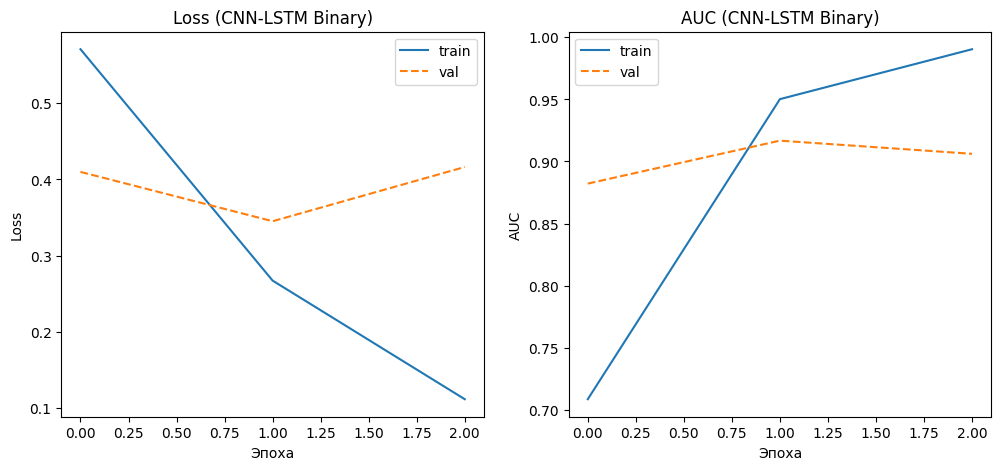

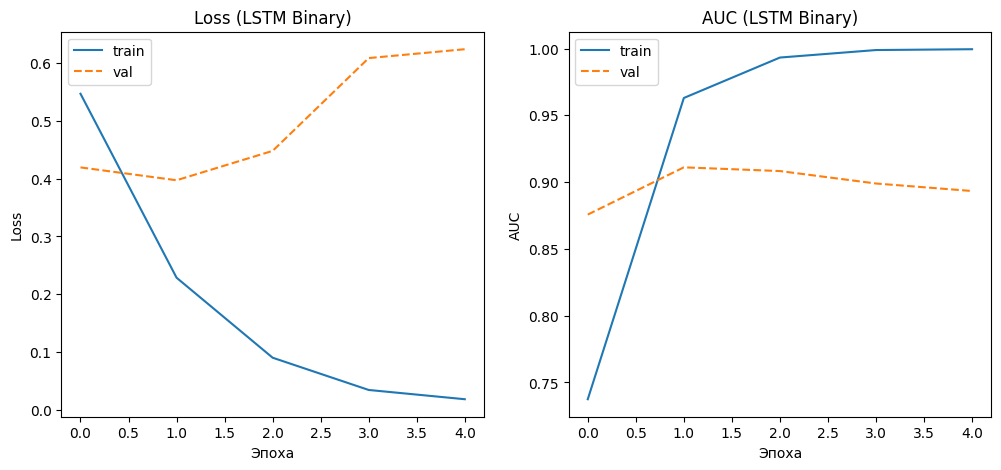

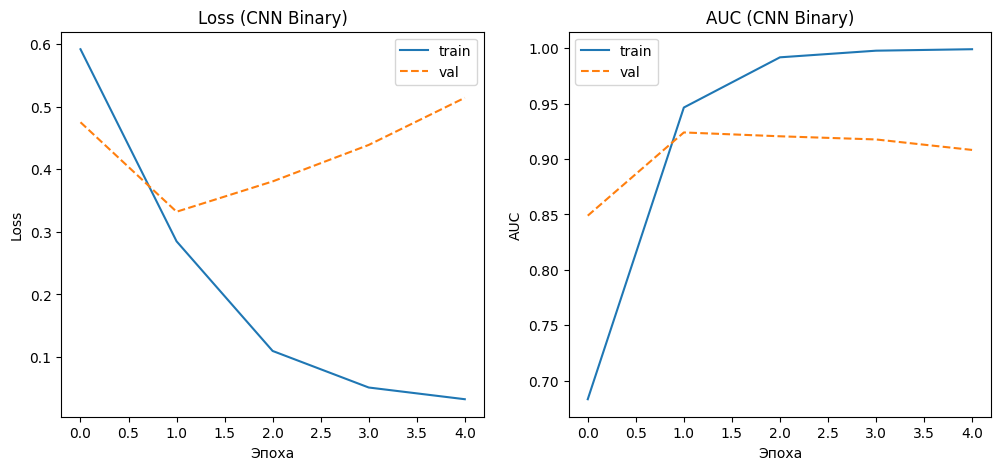

In [74]:
def plot_history_binary(history, name='CNN-LSTM Binary'):
    plt.figure(figsize=(12,5))
    
    # Потеря
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], '--', label='val')
    plt.title(f'Loss ({name})')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    
    # AUC
    plt.subplot(1,2,2)
    plt.plot(history.history['AUC'], label='train')
    plt.plot(history.history['val_AUC'], '--', label='val')
    plt.title(f'AUC ({name})')
    plt.xlabel('Эпоха')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.show()

plot_history_binary(history_cnn_lstm_bin, 'CNN-LSTM Binary')
plot_history_binary(history_bin, 'LSTM Binary')
plot_history_binary(history_bin2, 'CNN Binary')


Лучше всего себя показала модель LSTM, будем использовать ее для приложения streamlit

## Сохранение моделей

In [75]:
# Для мультиклассовой задачи
# model.save("cnn_lstm_multiclass.h5")
model2.save("lstm_multiclass.keras")
# model3.save("cnn_multiclass.h5")

# Для бинарной задачи
model_lstm.save("lstm_binary.keras")
# model_cnn.save("cnn_binary.h5")
# model_cnn_lstm_bin.save("cnn_lstm_binary.h5")